### ensemble(앙상블)
- 모델이 여러개
- 각각의 모델을 학습시킴
- 각 모델에 입력 parameter(이미지 픽셀)을 넣어서 예측값을 알아냄

In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

train_csv = pd.read_csv("./data/mnist/train.csv")
n = int(train_csv.shape[0] * 0.8)
test_csv = train_csv.loc[n:, :]
train_csv = train_csv.loc[:n-1, :]
real_test_csv = pd.read_csv("./data/mnist/test.csv")



### 0. 전처리
- 데이터를 test/train으로 나눠준다

### 1. NN학습
- CNN으로 학습
- xaviers init
- dropout
- adam optimzer

### 2. batch / epoch 나눠서 학습


In [33]:
# real data
x_real_test_data = real_test_csv

x_train_data.shape : (33600, 784), y_train_data.shape : (33600, 10)
x_test_data.shape : (8400, 784), y_test_data.shape : (8400, 10)


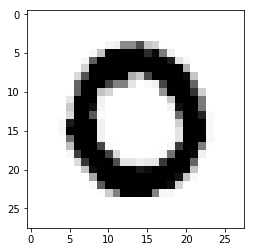

In [34]:
x_train_data = train_csv.drop("label", axis = 1)
y_train_data = pd.get_dummies(train_csv["label"])

x_test_data = test_csv.drop("label", axis = 1)
y_test_data = pd.get_dummies(test_csv["label"])

print("x_train_data.shape : {}, y_train_data.shape : {}".format(x_train_data.shape,y_train_data.shape))
print("x_test_data.shape : {}, y_test_data.shape : {}".format(x_test_data.shape,y_test_data.shape))

img = (x_train_data.loc[1,:].values).reshape(28,28)
# 0번째 행의 숫자 그려보기 
plt.imshow(img, cmap="Greys")
plt.show()

In [35]:
def set_weight(w_name, w_shape):
    return tf.get_variable(name =w_name, shape = w_shape,initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)

def set_bias(b_name, b_shape):
    return tf.Variable(tf.random_normal(b_shape), name = b_name, dtype =tf.float32)

def get_total_n(data, batch_size):
    return int(data.shape[0] / batch_size)


### LeNet (28x28 mnist)
- layer1
    - 1차원의 input 28x28
    - 3x3(1차원)필터 32개로 conv, padding = SAME
    - relu 후 pooling(2x2, strides = 2)
    - 12x12(1차원) 32개가 나옴
- layer2
    - 12x12(1차원) 32개를 input
    - 3x3(32차원)필터 64개로 conv, padding = SAME
    - relu 후 pooling(2x2, strides = 2)
    - 7x7(1차원)64개가 나옴
- fully connected
    - 7x7x16 (input)
    - 256 (hidden1)
    - 256 (hidden2)
    - 10 (output)


In [612]:
import math 

class CNNModel:
    def __init__(self,sess, name):
        self.name = name 
        self.sess = sess
        
        
    def create_network(self,input_x,input_y):
        
        with tf.variable_scope(self.name):
            self.X = tf.placeholder(shape = [None, input_x], dtype = tf.float32)
            self.Y = tf.placeholder(shape = [None, input_y], dtype = tf.float32)
            self.keep_rate = tf.placeholder(dtype= tf.float32)
            
            X_img = tf.reshape(self.X, shape = [-1, int(math.sqrt(input_x)), int(math.sqrt(input_x)), 1])
            

            W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
            L1 = self.layer_conv_relu(X_img, W1, [1,1,1,1], "SAME")
            L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

            W2 = set_weight("weight2", [3,3,32,64])
            L2 = self.layer_conv_relu(L1, W2, [1,1,1,1], "SAME")
            L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
            
            FC = tf.reshape(L2, shape=[-1, 7*7*64])

            FC_W1 = set_weight("fc_weight1", [7*7*64, 256])
            FC_b1 = set_bias( "fc_bias1", [256])
            _FC_L1 = tf.nn.relu(tf.matmul(FC,FC_W1) + FC_b1)
            FC_L1 = tf.nn.dropout(_FC_L1, keep_prob = self.keep_rate) 

            FC_W2 = set_weight("fc_weight2", [256, 256])
            FC_b2 = set_bias( "fc_bias2", [256])
            _FC_L2 = tf.nn.relu(tf.matmul(FC_L1,FC_W2) + FC_b2)
            FC_L2 = tf.nn.dropout(_FC_L2, keep_prob = self.keep_rate) 


            FC_W3 = set_weight("fc_weight3", [256, 10])
            FC_b3 = set_bias( "fc_bias3", [10])

            self.logit = tf.matmul(FC_L2, FC_W3) + FC_b3
            self.H = tf.nn.softmax(self.logit)

            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logit, labels = self.Y))
            optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.train = optimizer.minimize(self.cost)
            
            self.sess.run(tf.global_variables_initializer())
            
    def batch_train(self,epoch_size, batch_size, param, label):
        iter_of_num = int(param.shape[0] / batch_size)
        #self.sess.run(tf.global_variables_initializer())
        for ep in range(epoch_size):
            batch_start = 0
            for i in range(iter_of_num):
                batch_end = batch_start + batch_size
                # 마지막 iteration에서는 100개가 딱 안맞을수도 있음
                if i == iter_of_num-1:
                    x_batch = param.loc[batch_start:, :]
                    y_batch = label.loc[batch_start:, :]
                    _, self.cost_val = self.sess.run([self.train, self.cost], feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:0.7})
                else:
                    x_batch = param.loc[batch_start:batch_end-1, :]
                    y_batch = label.loc[batch_start:batch_end-1, :]
                    _, self.cost_val = self.sess.run([self.train, self.cost], feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:0.7})
                    batch_start = batch_end
            print("cost_val : {}".format(self.cost_val))
            
    def out_hypothesis(self,epoch_size, batch_size, param, label):
        iter_of_num = int(param.shape[0] / batch_size)
        H_np = np.zeros([1,10])
        for ep in range(epoch_size):
            batch_start = 0
            for i in range(iter_of_num):
                batch_end = batch_start + batch_size
                # 마지막 iteration에서는 100개가 딱 안맞을수도 있음
                if i == iter_of_num-1:
                    x_batch = param.loc[batch_start:, :]
                    y_batch = label.loc[batch_start:, :]
                    _, self.h_val = self.sess.run([self.train, self.H], feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:0.7})
                else:
                    x_batch = param.loc[batch_start:batch_end-1, :]
                    y_batch = label.loc[batch_start:batch_end-1, :]
                    _, self.h_val = self.sess.run([self.train, self.H], feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:0.7})
                    batch_start = batch_end
                H_np = np.append(H_np, self.h_val,axis=0)
        return H_np
    # label이 있는 test
    def batch_test_wl(self, ensemble_sum, batch_size, param, label):
        
        iter_of_num = int(param.shape[0] / batch_size)
        
        batch_start = 0
        accuracy_sum = 0

        
        for i in range(iter_of_num):
            print(batch_start)
            batch_end = batch_start + batch_size
            if i == iter_of_num-1:
                predict = tf.argmax(ensemble_sum[batch_start:], axis = 1)
            else:
                predict = tf.argmax(ensemble_sum[batch_start:batch_end], axis = 1)
            correct = tf.equal(predict, tf.argmax(self.Y, axis = 1))
            accuracy = tf.reduce_sum(tf.cast(correct, dtype = tf.float32))

            # 마지막 iteration에서는 100개가 딱 안맞을수도 있음
            if i == iter_of_num-1:
                x_batch = param.loc[batch_start:, :]
                y_batch = label.loc[batch_start:, :]
                batch_sum = self.sess.run(accuracy, feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:1.0})
            else:
                x_batch = param.loc[batch_start:batch_end-1, :]
                y_batch = label.loc[batch_start:batch_end-1, :]
                
                batch_sum = self.sess.run(accuracy, feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:1.0})
                batch_start = batch_end
            accuracy_sum += batch_sum
        print("accuracy : {}".format((accuracy_sum/param.shape[0])))
     
        
#     # label없이 뽑음
#     def batch_test_nl(self, batch_size, param):
#         iter_of_num = int(param.shape[0] / batch_size)
#         batch_start = 0
#         for i in range(iter_of_num):
#             batch_end = batch_start + batch_size
            
    
    def create_weight(self, w_name, w_shape):
        return tf.get_variable(name =w_name, shape = w_shape,initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    
    def create_bias(self, b_name, b_shape):
        return tf.Variable(tf.random_normal(b_shape), name = b_name, dtype =tf.float32)
    
    def layer_conv_relu(self, input_x, input_w, strides_shape, padding_val):
        layer = tf.nn.conv2d(input_x, input_w, strides=strides_shape, padding=padding_val)
        return tf.nn.relu(layer)
    
    def layer_max_pool(self, layer, ksize_shape, strides_shape, padding_val):
        return tf.nn.max_pool(layer, ksize = ksize_shape, strides = strides_shape,padding= padding_val)



In [589]:
x_test_data.shape
y_test_data.shape

(8400, 10)

In [615]:

sess = tf.Session()
cnn_test = CNNModel(sess,"cnn_test4")
cnn_test.create_network(784,10)
cnn_test.batch_test_wl(sum_hypothesis[1:],100, x_train_data, y_train_data)

x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), 

x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), 

x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), y_batch.shape : (100, 10)
x_batch.shape : (100, 784), 

InvalidArgumentError: Incompatible shapes: [770] vs. [100]
	 [[node Equal_421 (defined at <ipython-input-612-39f88d6da513>:105)  = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:GPU:0"](ArgMax_842, ArgMax_843)]]

Caused by op 'Equal_421', defined at:
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3215, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-615-35249c4fd9a3>", line 5, in <module>
    cnn_test.batch_test_wl(sum_hypothesis[1:],100, x_train_data, y_train_data)
  File "<ipython-input-612-39f88d6da513>", line 105, in batch_test_wl
    correct = tf.equal(predict, tf.argmax(self.Y, axis = 1))
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2734, in equal
    "Equal", x=x, y=y, name=name)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\gpu_env\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [770] vs. [100]
	 [[node Equal_421 (defined at <ipython-input-612-39f88d6da513>:105)  = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:GPU:0"](ArgMax_842, ArgMax_843)]]


In [600]:
sh =sum_hypothesis[1:]

In [567]:
tf.reset_default_graph()

In [568]:
cnn_list = []
sess = tf.Session()
for d in range(3):
    cnn = CNNModel(sess, "cnn"+str(d))
    cnn.create_network(784,10)
    cnn_list.append(cnn)

In [569]:
sum_hypothesis = 0 
for cnn in cnn_list:
    sum_hypothesis += cnn.out_hypothesis(1,100,x_train_data,y_train_data)


In [577]:
sum_hypothesis.sum(axis=1)

array([0.        , 3.        , 2.99999982, ..., 3.00000006, 2.9999999 ,
       2.99999997])

In [ ]:
predict = tf.argmax(sum_hypothesis[1:], axis = 1)
correct = tf.eqaul(predict, y_train_data)

In [582]:
sum_hypothesis[1:]

array([[3.67460895e-01, 9.58108129e-01, 3.79768602e-02, ...,
        1.90135606e-01, 3.49145957e-02, 2.91410901e-02],
       [9.40426067e-03, 6.58369636e-02, 9.13267788e-02, ...,
        3.27687317e-02, 1.99866069e-01, 1.04633949e-01],
       [1.12332345e-01, 1.23979345e+00, 1.92003176e-02, ...,
        5.39303079e-01, 1.17040006e-01, 1.02978544e-01],
       ...,
       [2.99966234e+00, 9.48877538e-06, 6.59326446e-06, ...,
        2.18883593e-05, 1.33738191e-05, 4.12156834e-07],
       [4.75947304e-05, 1.10842538e-02, 2.96664339e+00, ...,
        2.61867118e-03, 6.68773406e-04, 2.58414810e-05],
       [2.32777905e-09, 1.20729299e-04, 2.99986494e+00, ...,
        4.38986020e-06, 4.82021109e-06, 1.80301239e-06]])

In [575]:
# 맨 앞 0행은 np.append 원할하게하기위해 그냥 넣어준 값이니 빼고
ensemble_argmax = tf.argmax(sum_hypothesis[1:],axis=1)
sess = tf.Session()
sess.run(ensemble_argmax)

array([1, 3, 1, ..., 0, 2, 2], dtype=int64)

In [505]:
sess.run(tf.global_variables_initializer())
ccx = cnn1.out_hypothesis(1,100,x_train_data,y_train_data)


In [473]:
zz0 = np.zeros([1,10])

In [477]:
print(zz0.shape)

(1, 10)


In [470]:
zz0 = np.array([-1,10])
zz1 = cnn1.sess.run(cnn1.H, feed_dict={cnn1.X:a, cnn1.Y:b, cnn1.keep_rate:1.0})
zz2 = cnn1.sess.run(cnn1.H, feed_dict={cnn1.X:a, cnn1.Y:b, cnn1.keep_rate:1.0})

In [471]:
print(zz0.shape)
print(zz1.shape)
print(zz2.shape)

(2,)
(3, 10)
(3, 10)


In [478]:
cc = np.append(zz0,zz2, axis = 0)

In [479]:
cc.shape

(4, 10)

In [443]:
xx = tf.argmax(zz, axis=1)
cnn1.sess.run(xx, feed_dict={cnn1.X:a, cnn1.Y:b, cnn1.keep_rate:1.0})


array([0, 1, 4], dtype=int64)

In [416]:
x_train_data.shape[0]/ 100

336.0

In [417]:
a

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [418]:
b

,0,1,2,3,4,5,6,7,8,9
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0


In [410]:
cnn1.sess.run(tf.global_variables_initializer())
cnn1.sess.run(cnn1.H, feed_dict={cnn1.X:a, cnn1.Y:b, cnn1.keep_rate:1.0})

array([[1.85274296e-02, 4.37102839e-02, 1.01411929e-02, 9.44328058e-05,
        3.68489861e-03, 1.26980450e-02, 1.91677898e-01, 1.49447257e-02,
        5.28089881e-01, 1.76431194e-01],
       [9.18082148e-03, 7.42701069e-02, 2.50383466e-02, 2.58514221e-04,
        3.98048246e-03, 4.89071906e-02, 9.98629928e-02, 4.84301865e-01,
        1.81765169e-01, 7.24345371e-02],
       [1.33641930e-02, 9.49082896e-02, 2.22598258e-02, 2.88022857e-04,
        2.02309638e-02, 4.86913994e-02, 3.49116147e-01, 1.30001739e-01,
        2.14486182e-01, 1.06653266e-01]], dtype=float32)

# 앙상블 전 99%

In [595]:
# tensorflow 초기화
tf.reset_default_graph()


# placeholder 
X = tf.placeholder(shape = [None, 784], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 10], dtype = tf.float32)
keep_rate = tf.placeholder(dtype= tf.float32)

# input conv img
X_img = tf.reshape(X, shape = [-1, 28,28,1])

W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
L1 = tf.nn.conv2d(X_img, W1, strides = [1,1,1,1], padding="SAME")
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

W2 = set_weight("weight2", [3,3,32,64])
L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding="SAME")
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
print(L2)
FC = tf.reshape(L2, shape=[-1, 7*7*64])

FC_W1 = set_weight("fc_weight1", [7*7*64, 256])
FC_b1 = set_bias( "fc_bias1", [256])
_FC_L1 = tf.nn.relu(tf.matmul(FC,FC_W1) + FC_b1)
FC_L1 = tf.nn.dropout(_FC_L1, keep_prob = keep_rate) 

FC_W2 = set_weight("fc_weight2", [256, 256])
FC_b2 = set_bias( "fc_bias2", [256])
_FC_L2 = tf.nn.relu(tf.matmul(FC_L1,FC_W2) + FC_b2)
FC_L2 = tf.nn.dropout(_FC_L2, keep_prob = keep_rate) 


FC_W3 = set_weight("fc_weight3", [256, 10])
FC_b3 = set_bias( "fc_bias3", [10])

logit = tf.matmul(FC_L2, FC_W3) + FC_b3
H = tf.nn.softmax(logit)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit, labels = Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_epoch = 1
batch_size = 100

# loc는 이상,이하로 범위 슬라이싱 
for step in range(train_epoch):
    num_of_iter = get_total_n(x_train_data, batch_size)
    batch_start = 0
    for i in range(num_of_iter):
        batch_next = batch_start + batch_size
        if i ==  num_of_iter-1:
            xtd = x_train_data.loc[batch_start:,:]
            ytd = y_train_data.loc[batch_start:,:]
            _, cost_val = sess.run([train,cost], feed_dict={X: xtd, Y: ytd, keep_rate: 0.7})
        else:
            xtd = x_train_data.loc[batch_start:batch_next-1,:]
            ytd = y_train_data.loc[batch_start:batch_next-1,:]
            _, cost_val = sess.run([train,cost], feed_dict={X: xtd, Y: ytd, keep_rate: 0.7})
            batch_start = batch_next
    if step % 5 == 0:
        print("cost_val : {}".format(cost_val))
           


Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
cost_val : 0.4273631274700165


In [596]:
x_test_data = pd.DataFrame(x_test_data.values, columns=x_test_data.columns)
y_test_data = pd.DataFrame(y_test_data.values, columns=y_test_data.columns)

In [598]:
predict = tf.argmax(H, axis = 1)

correct = tf.equal(predict, tf.argmax(Y, axis = 1))
accuracy = tf.reduce_sum(tf.cast(correct, dtype = tf.float32))

num_iter = get_total_n(x_test_data, batch_size)
batch_start = 0
accuracy_sum = 0

for i in range(num_iter):
    batch_next = batch_start + batch_size
    if i ==  num_of_iter-1:
        xtd = x_test_data.loc[batch_start:,:]
        ytd = y_test_data.loc[batch_start:,:]
        batch_sum = sess.run(accuracy, feed_dict={X: xtd, Y: ytd, keep_rate: 1.0})
    else:
        xtd = x_test_data.loc[batch_start:batch_next-1,:]
        ytd = y_test_data.loc[batch_start:batch_next-1,:]
        #print("xtd.shape : {}, ytd.shape : {}".format(xtd.shape, ytd.shape))
        batch_sum = sess.run(accuracy, feed_dict={X: xtd, Y: ytd, keep_rate: 1.0})
        a = sess.run(predict, feed_dict={X: xtd, Y: ytd, keep_rate: 1.0})
        #print("batch_sum : {}, start : {}, end : {}".format(batch_sum,batch_start, batch_next))
        batch_start = batch_next
        
    accuracy_sum += batch_sum
print("accuracy : {}".format((accuracy_sum/x_test_data.shape[0])))
print(a.shape)

<class 'tensorflow.python.framework.ops.Tensor'>
accuracy : 0.9557142857142857
(100,)


### test data 예측

In [39]:
accuracy_list = []
result = []
num_iter = x_real_test_data.shape[0]
batch_size = 100
batch_start = 0
for i in range(num_iter):
    batch_next = batch_start + batch_size
    if i ==  num_of_iter-1:
        xtd = x_real_test_data.loc[batch_start:,:]
        ytd = x_real_test_data.loc[batch_start:,:]
        accuracy_list = sess.run(predict, feed_dict={X: xtd, keep_rate: 1.0})
    else:
        xtd = x_real_test_data.loc[batch_start:batch_next-1,:]
        ytd = x_real_test_data.loc[batch_start:batch_next-1,:]
        #print("xtd.shape : {}, ytd.shape : {}".format(xtd.shape, ytd.shape))
        accuracy_list = sess.run(predict, feed_dict={X: xtd, keep_rate: 1.0})
        #print("batch_sum : {}, start : {}, end : {}".format(batch_sum,batch_start, batch_next))
        batch_start = batch_next
    for r in accuracy_list:
        result.append(r)

In [40]:
df_predict = pd.DataFrame(result, columns = ["label"])
digit_predict = pd.concat([df_predict, x_real_test_data], axis = 1)
print(digit_predict.shape)
digit_predict.to_csv("digit_predict.csv", sep = ',',index=False)


(28000, 785)


In [41]:
data = pd.read_csv("./digit_predict.csv",sep=",")
label_ = data["label"]
ImageId_ = np.arange(1,28001)

In [42]:
digit_pd = pd.DataFrame(ImageId_,columns=["ImageId"])
digit_pd["Label"] = label_

In [43]:
digit_pd.to_csv("digit_pd.csv", sep = ',',index=False)